In [30]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

sns.set()

In [4]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Preprocess Data

## Fix Null Field Positions

In [5]:
print("Before")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())

# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)

print("After")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

Before
6424
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
After
0
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50


## Downsample, keep only entries where players is rusher

In [6]:
print("Before")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

# Only keep entries associated with rusher
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

print("After")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

Before
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)
After
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


## Calculate yards remaining (new feature)

In [7]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


## Fix Defenders In Box Feature

Before
1 in Box Count: 1
2 in Box Count: 1
NaN in Box Count: 3
After
1 in Box Count: 0
2 in Box Count: 0
NaN in Box Count: 0


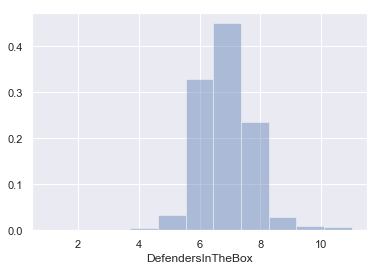

In [8]:
print("Before")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))
sns.distplot(df.DefendersInTheBox[df.DefendersInTheBox.isnull()==False], bins=11, kde=False, norm_hist=True)

# Fill nan with median (i.e. 7), and bump 1 or 2 (few samples) up to 3
df.DefendersInTheBox.fillna(7, inplace=True)
df.DefendersInTheBox.replace(to_replace=[1, 2], value=3, inplace=True)

print("After")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))

## Fix Position Feature

Before 

Position
CB        9
DE        1
DT        2
FB      169
HB      616
QB       77
RB    21628
TE       31
WR      638
dtype: int64

 After
Position
FB         169
HB         616
Other       12
QB          77
RB       21628
TE          31
WR         638
dtype: int64


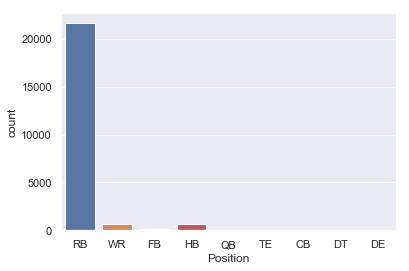

In [9]:
print("Before \n")
print(df.groupby(['Position']).size())
sns.countplot(x="Position", data=df)

# Change 'CB', 'DE', 'DT' (few samples) to 'Other'
df.Position.replace(to_replace=['CB', 'DE', 'DT'], value='Other', inplace=True)

print("\n After")
print(df.groupby(['Position']).size())

# Train and Dev Split

In [85]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 50)
(6952, 50)


# Fit Random Forest

## Helper Functions

In [123]:
def y_ohe(y):
    """ Function to convert yards gained to 199 length vector for PMF"""
    n_example = y_train.shape[0]
    y_ohe = np.zeros((n_example, 199))
    np.array(y_train)[0]
    for example in range(0, n_example):
        y_ohe[example, 99+np.array(y_train)[example]] = 1
    return y_ohe

In [124]:
# https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d
class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [125]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

## Apply Helper Functions to Training Data

In [153]:
X_train = train[["A", "Down", "DefendersInTheBox", "Position", "YardsRemaining"]]
X_dev = dev[["A", "Down", "DefendersInTheBox", "Position", "YardsRemaining"]]
y_train = train["Yards"]
#yards_remaining_train = train["YardsRemaining"]
y_dev = dev["Yards"]
print(X_train)
print(y_train)

          A  Down  DefendersInTheBox Position  YardsRemaining
15685  3.27     2                7.0       RB            16.0
1178   3.28     1                6.0       RB            43.0
317    0.93     2                8.0       RB            37.0
17159  2.36     2                8.0       RB            35.0
14100  1.39     1                6.0       RB            64.0
...     ...   ...                ...      ...             ...
10955  2.36     1                8.0       RB            70.0
17289  5.45     1                6.0       RB            68.0
5192   3.52     1                6.0       RB            60.0
12172  2.26     1                7.0       RB            40.0
235    1.02     3                8.0       RB            58.0

[16219 rows x 5 columns]
15685     9
1178      4
317       0
17159    -3
14100     9
         ..
10955     2
17289    18
5192      0
12172    -5
235       0
Name: Yards, Length: 16219, dtype: int64


In [154]:
le = MultiColumnLabelEncoder(columns = ["Down", "DefendersInTheBox", "Position"])
X_train_le = le.fit_transform(X_train)
X_train_ohe = ohe.fit_transform(X_train_le)
print(X_train_ohe.shape)

(16219, 735)


In [155]:
#y_train_ohe = y_ohe(y_train)
#print(y_train_ohe.shape)

## Fit model

In [156]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, min_samples_split=20, min_samples_leaf=10)

In [157]:
clf.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Test model

In [158]:
X_dev_le = le.fit_transform(X_dev)
X_dev_ohe = ohe.transform(X_dev_le)
print(X_dev_ohe.shape)

(6952, 735)


In [167]:
# What do our predictions mean?
print(len(y_train.unique()))
print(sorted(y_train.unique()))

91
[-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 87, 90, 92, 97, 99]


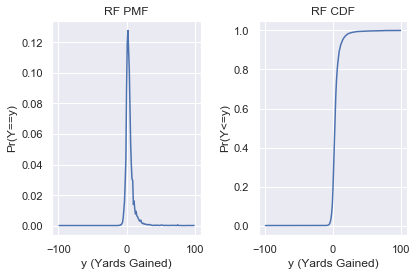

In [193]:
n_example, n_feature = X_dev_ohe.shape
y_dev_pred = clf.predict_proba(X_dev_ohe)

# calculate pmf 
pred_vals = sorted(y_train.unique())
yard_probabilities = np.zeros((n_example, 199))
for example in range(0, n_example):
    for y in range(0, len(pred_vals)):
            yard_probabilities[example, 99+pred_vals[y]] = (y_dev_pred[example])[y]

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities, axis = 1)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities[0, :])
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='RF PMF')
axes[1].plot(np.arange(-99,100), yard_cdf[0, :])
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='RF CDF')
plt.tight_layout()

## Squashing probabilities 

In [187]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

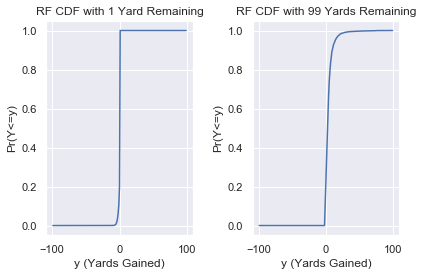

In [189]:
one_cdf = squash(yard_cdf[0, :], 1)
ninenine_cdf = squash(yard_cdf[0, :], 99)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), one_cdf)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='RF CDF with 1 Yard Remaining')
axes[1].plot(np.arange(-99,100), ninenine_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='RF CDF with 99 Yards Remaining')
plt.tight_layout()

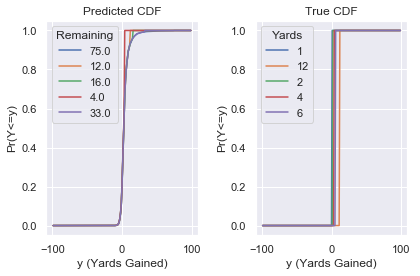

In [194]:
fig, axes = plt.subplots(1, 2)

example = 0
for index, row in dev.head().iterrows():
    pred_cdf = squash(yard_cdf[example, :], int(row['YardsRemaining']))
    axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])
    (pred_cdf-true_cdf)**2
    example += 1

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

## Loss for model using all of the data

In [195]:
example = 0
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf[example, :], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
    example += 1
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.0140161443531185
